# Illustration of the K-Means Algorithm

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* The simple k-means algorithm for hard clustering
* Convergence of the k-means algorithm for different datasets
* Generating an animated GIF of the convergence process

In [35]:
import numpy as np
import matplotlib as mpl
#mpl.use('TkAgg')
import matplotlib.pyplot as plt
import sklearn.datasets as sk
from matplotlib import animation
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.
%matplotlib inline

The k-means algorithm is one of the most popular **clustering algorithms** and very simple with respect to the implementation. Clustering has the goal to categorize a set of 
objects into different clusters, such that the properties of the objects in one cluster are as close as possible.
Objects of different clusters should have dissimilar properties.  
This following jupyter notebook implements and visualizes the $k$-means clustering algorithm.

At first we choose a data set on which we want to apply the clustering.
Choose one of the following data sets or define your own one:  
1. **Phase shifted QPSK constellation with AWGN**.  
   *(as a communications related example)*  
   Due to the phase shift, we cannot use our common fixed axis decision borders. Instead of a phase synchronization, 
   we apply the $k$-means algorithm to quantize each constellation point to 1 of 4 QPSK symbols. 
   This is an easy data set, because we can visually separate the 4 clusters. 
   By increasing the noise power, the clusters become more and more blurred.
2. **Anisotropically distributed Gaussian blobs**.
   Another example of visually separable blobs.
3. **Anisotropically distributed Gaussian blobs**.
   Datasets are closer togehter than in 2.
4. **Uniform distribution**.  
   Visually not separable.
5. **Concentric circles**.  
   This is an example where the downside of $k$-means is shown. Because the algorithm assumes that the elements of each
   cluster are located within a sphere around the center of the cluster, these 2 concentric circles cannot be separated
   despite the fact, that one can separate them visually pretty well.
6. **Two interleaving half circles**.  
   Another example one which the algorithm fails.


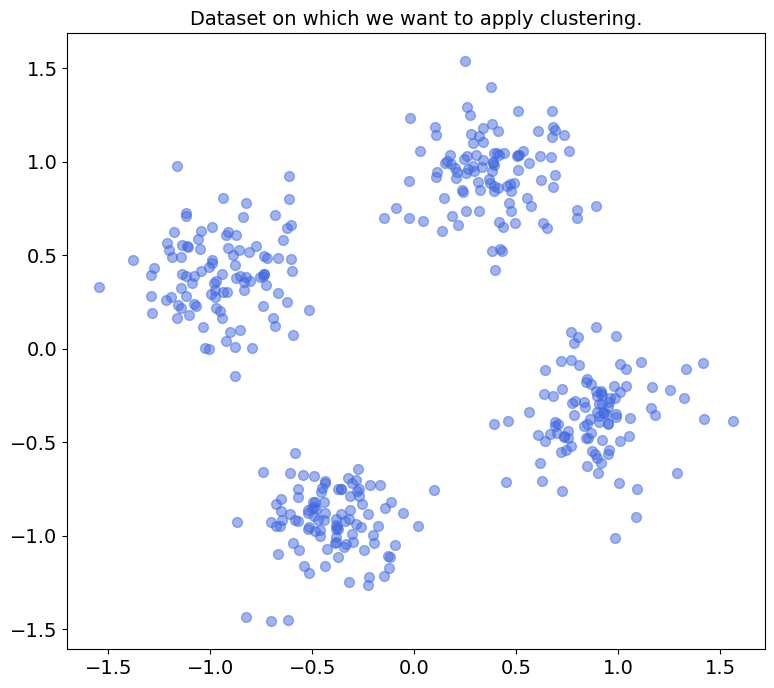

In [36]:
data_selection = 1 # Choose your data set.

if data_selection==1:
    m = 4 # 4 classes for QPSK demodulation
    N = m*100 # must be divisible by 4
    phase_shift = -np.pi/8 # phase shift
    # index to symbol mapper
    number2symbol = {
        0 : np.array([1.0*np.cos(phase_shift), 1.0*np.sin(phase_shift)]),
        1 : np.array([1.0*np.sin(phase_shift), -1.0*np.cos(phase_shift)]),
        2 : np.array([-1.0*np.cos(phase_shift), -1.0*np.sin(phase_shift)]),
        3 : np.array([-1.0*np.sin(phase_shift), 1.0*np.cos(phase_shift)])
    }
    training_set = np.array([])
    for i in range(0, m): # Assign N/4 constellation points to each QPSK symbol.
        constellation_points = np.add(np.random.randn(N//m,2)/5, number2symbol[i])
        training_set = np.concatenate((training_set, constellation_points)) \
            if training_set.size else constellation_points
elif data_selection==2:
    m = 3 # You can change m arbitrarily.
    N = 800
    random_state = 7
    transformation = [[1.0, 0.1], [-0.5, 0.3]]
    training_set = np.dot(sk.make_blobs(n_samples=N, centers=m, n_features=2, random_state=random_state)[0],transformation)
elif data_selection==3:
    m = 3 # You can change m arbitrarily.
    N = 200 
    random_state = 170 
    transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
    training_set = np.dot(sk.make_blobs(n_samples=N, centers=m, n_features=2, random_state=random_state)[0],transformation)
elif data_selection==4:
    m = 6 # You can change m arbitrarily.
    N = m*100
    training_set = np.random.rand(N,2)
elif data_selection==5:
    m = 2
    N = 200
    training_set = sk.make_circles(n_samples=N, noise=0.05, random_state=None, factor=0.4)[0]
elif data_selection==6:
    m = 2
    N = 200
    training_set = sk.make_moons(n_samples=N, noise=.05)[0]
# Plot data set.
plt.figure(num=None, figsize=(9, 8))
plt.scatter(training_set[:,0], training_set[:,1], marker='o', c='royalblue', s=50, alpha=0.5)
plt.title('Dataset on which we want to apply clustering.', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.show()


Now we apply the $k$-means algorithm. Therefore we:  
* Set the maximum number of iterations.  
* Set random inital center positions.  
* Iteratively:  
  1. **Assignment step**: Calculate Euclidean distances between 
  each data point and each center position and assign to nearest one.  
  2. Plot the assigned data points (just for visualization).
  3. **Update step**: Move each center point to the average position of the data points
  which are currently assigned to this center. If a center point has no assigned data points at all, define a new random position.
  (This is not part of the original algorithm. You can disable this feature at the beginning of the following code.)
  4. **Stop** if movement of the center positions is below a certain threshold
   or if the maximum number of iterations is reached.

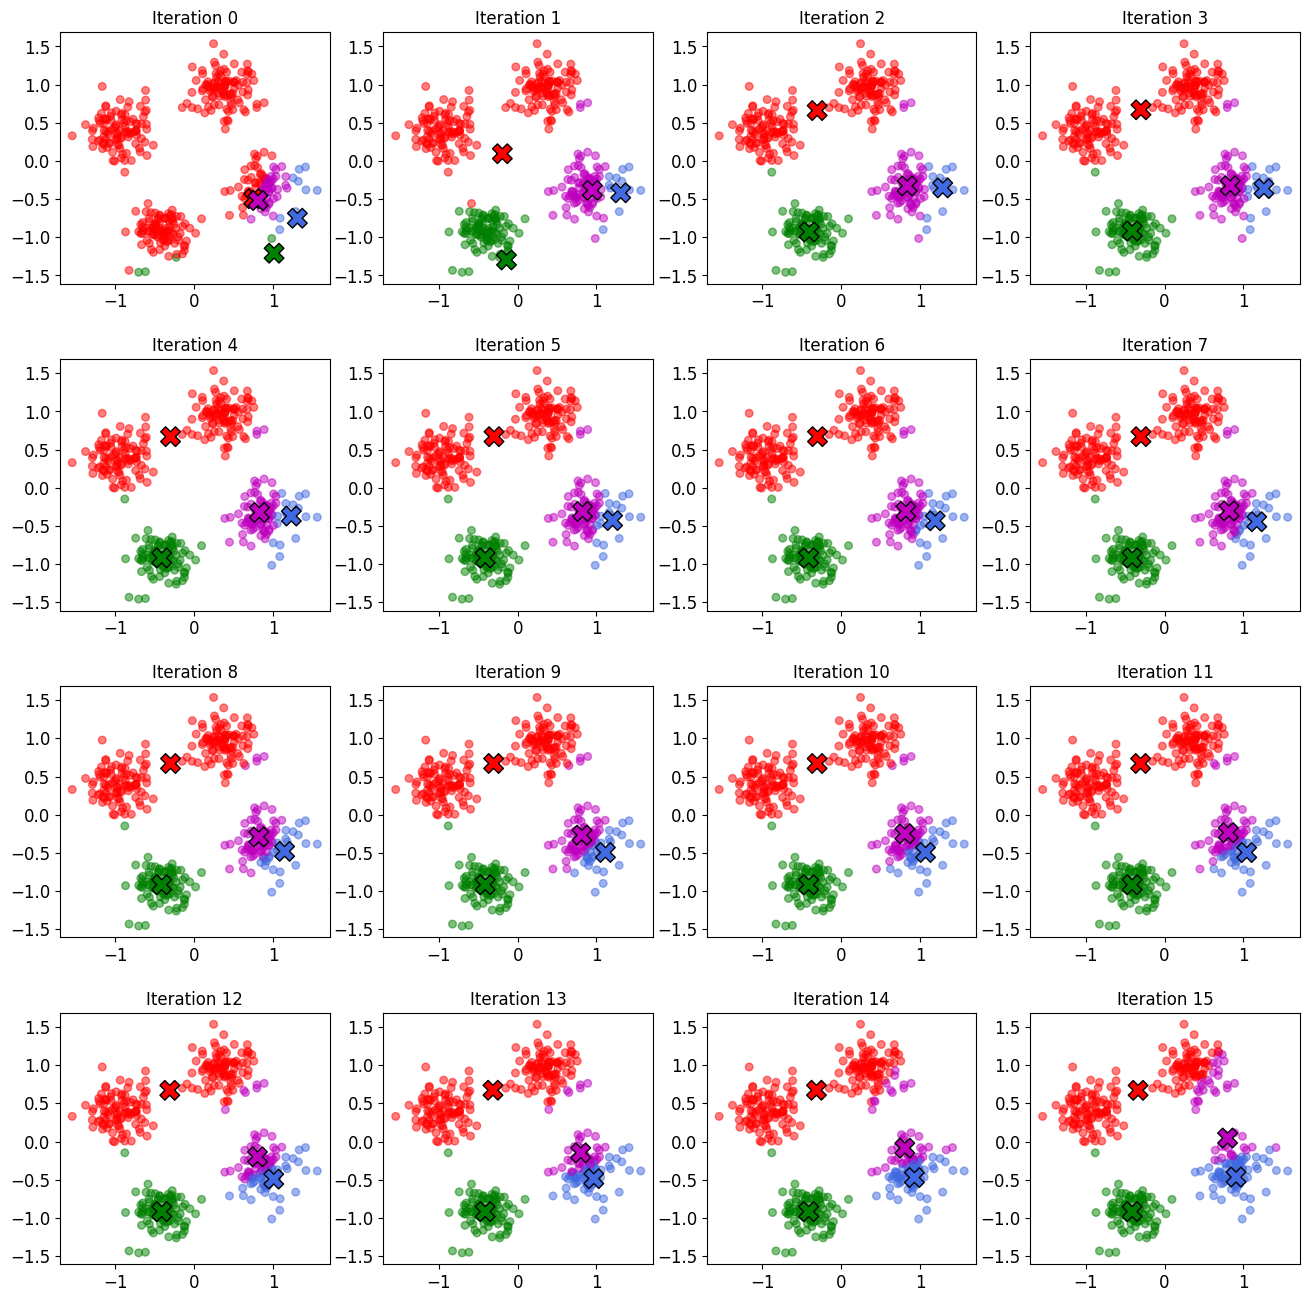

In [37]:
max_iter = 16 # Set the maximum number of iterations.
update_empty_centers = True # If True, a center point with no assigned data points gets a new random position.
# Set random init center positions in range of training_data.
def get_rand_centers(num):
    centers_x1 = (np.max(training_set[:,0])-np.min(training_set[:,0]))*np.random.rand(num)+np.min(training_set[:,0])
    centers_x2 = (np.max(training_set[:,1])-np.min(training_set[:,1]))*np.random.rand(num)+np.min(training_set[:,1])
    return np.stack((centers_x1, centers_x2), axis=1)
centers = get_rand_centers(m)
new_centers =  np.empty([m,2])
center_history = np.array([centers])
argmin_history = np.empty((0,N))


# Prepare plot.
fig = plt.figure(1, figsize=(16,4*(-(-max_iter//4))))
if m > 6:
    cmap=plt.cm.Paired
else:
    cmap = mpl.colors.ListedColormap(['royalblue', 'red', 'green', 'm', 'darkorange', 'gray'][:m])
boundaries = np.arange(0,m,1.0)
norm = mpl.colors.BoundaryNorm(np.arange(0,m+1,1), cmap.N)

# Start iteration.
for n in range(0,max_iter):
    # Calculate the Euclidean distance from each data point to each center point.
    distances = np.sqrt(np.subtract(training_set[:,0,None],np.repeat(np.array([centers[:,0]]), repeats=N, axis=0))**2 + np.subtract(training_set[:,1,None],np.repeat(np.array([centers[:,1]]), repeats=N, axis=0))**2)
    # Assignment step. Identify the closest center point to each data point.
    argmin = np.argmin(distances, axis=1)
    argmin_history = np.append(argmin_history, [argmin], axis=0)
    
    # Plot current center positions and center assignments of the data points.
    ax = fig.add_subplot(-(-max_iter//4), 4, n+1)
    plt.scatter(training_set[:,0], training_set[:,1], marker='o', s=30, c=argmin, cmap=cmap, norm=norm, alpha=0.5)
    plt.scatter(centers[:,0], centers[:,1], marker='X', c=np.arange(0,m,1), cmap=cmap, norm=norm, edgecolors='black', s=200)
    plt.tick_params(axis='both', labelsize=12)
    plt.title('Iteration %d' % n, fontsize=12)
    
    # Update step.
    for i in range(0,m):
        new_centers[i] = np.sum(training_set[argmin==i], axis=0) / len(argmin[argmin==i]) if len(argmin[argmin==i])>0 else get_rand_centers(1) if update_empty_centers else centers[i]
    
    # Calc the movement of all center points as a stopping criterion.
    center_movement = np.sum(np.sqrt((new_centers[:,0]-centers[:,0])**2 + (new_centers[:,1]-centers[:,1])**2))
    if center_movement < 0.0001:
        print("Finished early after %d iterations." % n)
        break
    centers = np.array(new_centers, copy=True)
    center_history = np.append(center_history, [centers], axis=0)

fig.subplots_adjust(hspace=0.3)
plt.show()

Visualize the trajectory of the center positions.

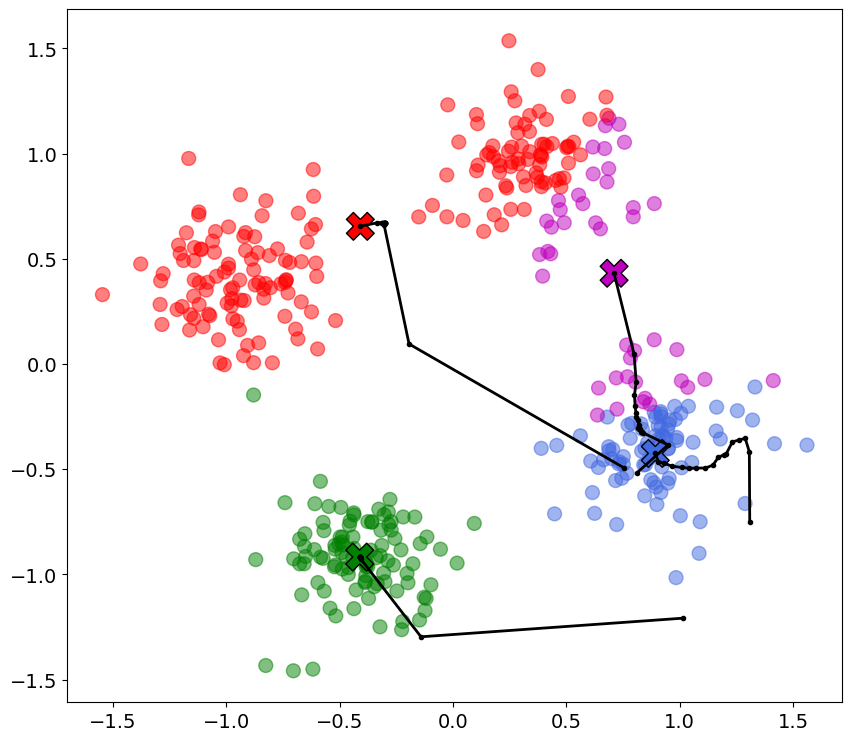

In [38]:
# Plot trajectory of center positions.
plt.figure(num=None, figsize=(10, 9))
plt.scatter(training_set[:,0], training_set[:,1], marker='o', s=100, c=argmin, cmap=cmap, norm=norm, alpha=0.5)
plt.plot(center_history[:,:,0], center_history[:,:,1],marker='.',color='k',linewidth=2)
plt.scatter(centers[:,0], centers[:,1], marker='X', c=np.arange(0,m,1), cmap=cmap, norm=norm, edgecolors='black', s=400)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('k_means_gauss_trajectory.pdf',bbox_inches='tight')
plt.show()

Visualize with matplotlib animation.
If the animation returns errors you can:  
*  Disable fig.show() and save the gif externally (uncomment the corresponding line in the code).
*  Use the jupyter notebook k_means.ipynb (without animation).

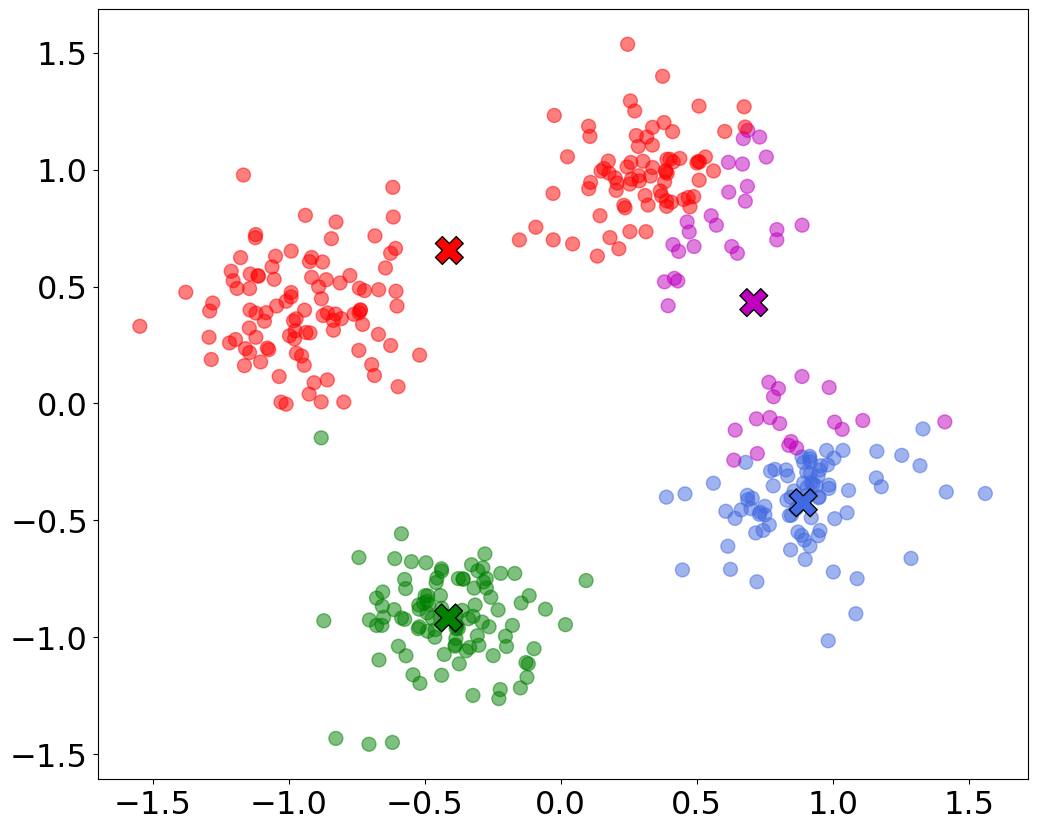

In [ ]:
%matplotlib inline
#%matplotlib notebook
# First set up the figure, the axis, and the plot element we want to animate.
fig = plt.figure(num=None, figsize=(12, 10))
ax = plt.axes()
plt.tick_params(axis='both', labelsize=23)
scat_train = ax.scatter(training_set[:,0], training_set[:,1], marker='o', s=100, c=argmin, cmap=cmap, norm=norm, alpha=0.5)
scat_center = ax.scatter(centers[:,0], centers[:,1], marker='X', c=np.arange(0,m,1), cmap=cmap, norm=norm, edgecolors='black', s=400)
lines = []
for n in range(0,m):
    line, = ax.plot([], [], marker='.',color='k',linewidth=2)
    lines.append(line)

# Initialization function.
def init():
    return scat_center,

# Animation function.  This is called sequentially.
def animate(i):
    scat_center.set_offsets(center_history[i,:,:])
    scat_train.set_array(argmin_history[i])
    for n in range(0,m):
        lines[n].set_data(center_history[0:i+1,n,0], center_history[0:i+1,n,1])
    ax.set_title("Iteration {}".format(i), fontsize=20)
    return scat_center,

# Call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(argmin_history), interval=2000, blit=True)

# If you want to save the animation, use the following line.

fig.show()
#anim.save('k_means.gif', writer=PillowWriter(fps=.5))